In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Bi-IV/cnews文本分类")

Mounted at /content/drive


# Action1_cnews 中文文本分类

由清华大学根据新浪新闻RSS订阅频道2005-2011年间的历史数据筛选过滤生成     训练集 50000     验证集 5000     测试集 10000     词汇（字） 5000     10个分类，包括：'体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐'

In [5]:
# 设置数据目录
train_file = 'cnews.train.small.txt'
test_file = 'cnews.test.txt'
val_file = 'cnews.val.txt'
vocab_file = 'cnews.vocab.txt'

In [6]:
import torch
from torch import nn
from model import TextRNN
from cnews_loader import read_vocab,read_category,process_file
from torch import optim

In [7]:
# 获取文本的类别及其对应id的字典
categories, cat_to_id = read_category()
print('categories={},\ncat_to_id={}'.format(categories,cat_to_id))
# 获取训练文本中所有出现过的字及其所对应的id
# word_to_id = {'<PAD>': 0, '，': 1, '的': 2, '。': 3, '一': 4, '是': 5......}
words, word_to_id = read_vocab('cnews.vocab.txt') 
print('words={},\nword_to_id={}'.format(words[:108],dict(list(word_to_id.items())[:10])))
# 获取训练数据每个字的id和对应标签的one-hot形式
# x_train.shape = (1000,600),y_train.shape = (1000,10)
x_train, y_train = process_file(train_file, word_to_id, cat_to_id, 600)
print('x_train.shape={},\ny_train.shape={}'.format(x_train.shape,y_train.shape))
x_val, y_val = process_file(val_file, word_to_id, cat_to_id, 600)
print('x_val.shape={},\ny_val.shape={}'.format(x_val.shape,y_val.shape))


categories=['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐'],
cat_to_id={'体育': 0, '财经': 1, '房产': 2, '家居': 3, '教育': 4, '科技': 5, '时尚': 6, '时政': 7, '游戏': 8, '娱乐': 9}
words=['<PAD>', '，', '的', '。', '一', '是', '在', '0', '有', '不', '了', '中', '1', '人', '大', '、', '国', '', '2', '这', '上', '为', '个', '“', '”', '年', '学', '时', '我', '地', '和', '以', '到', '出', '来', '会', '行', '发', '：', '对', '们', '要', '生', '家', '他', '能', '也', '业', '金', '3', '成', '可', '分', '多', '现', '5', '就', '场', '新', '后', '于', '下', '日', '经', '市', '前', '过', '方', '得', '作', '月', '最', '开', '房', '》', '《', '高', '9', '8', '.', '而', '比', '公', '4', '说', ')', '将', '(', '都', '资', 'e', '6', '基', '用', '面', '产', '还', '自', '者', '本', '之', '美', '很', '同', '', '7', '部', '进'],
word_to_id={'<PAD>': 0, '，': 1, '的': 2, '。': 3, '一': 4, '是': 5, '在': 6, '0': 7, '有': 8, '不': 9}
x_train.shape=(10000, 600),
y_train.shape=(10000, 10)
x_val.shape=(5000, 600),
y_val.shape=(5000, 10)


In [8]:
import torch.utils.data as Data
import numpy as np
# 设置GPU
cuda = torch.device('cuda')
x_train, y_train = torch.LongTensor(x_train), torch.Tensor(y_train).to(dtype=torch.int64)
x_val, y_val = torch.LongTensor(x_val), torch.Tensor(y_val).to(dtype=torch.int64)

# .TensorDataset检查x_train和y_train第一维是否相同，相同则继续
# (1000,600)(1000,10)，assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
train_dataset = Data.TensorDataset(x_train, y_train)  
val_dataset = Data.TensorDataset(x_val, y_val)
#
train_loader = Data.DataLoader(dataset = train_dataset, batch_size=256, shuffle=True)
val_loader = Data.DataLoader(dataset = val_dataset, batch_size=256)

In [9]:
x_train,y_train

(tensor([[1609,  659,   56,  ...,    9,  311,    3],
         [   2,  101,   16,  ..., 1168,    3,   24],
         [ 465,  855,  521,  ...,  116,  136,   85],
         ...,
         [   0,    0,    0,  ...,  603, 1791, 1474],
         [   0,    0,    0,  ...,   96,  630,    3],
         [ 314, 1525,  332,  ...,   10,    3,   24]]),
 tensor([[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0]]))

In [10]:
loss_list = []
loss_epoch_list = []
accuracy_epoch_list = []
accuracy_mean_list = []   # 每个epoch计算一次accuracy平均
loss_epochMean_list = []   # 每个epoch计算一次loss平均
EPOCH = 100
def train():
    model = TextRNN().cuda()
    # 定义损失函数
    Loss = nn.MultiLabelSoftMarginLoss() # 多类别（multi-class）多分类（multi-classification）的 Hinge 损失
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    
    best_val_acc = 0
    
    for epoch in range(EPOCH):
        print('***********************************************************')
        print('epoch=',epoch)
        # 分批训练
        temp_loss = 0
        accuracy_mean = 0
        for step, (x_batch, y_batch) in enumerate(train_loader):
            
            x = x_batch.cuda()  #[128, 600]
            y = y_batch.cuda() # [128, 10]
            # 前向传播
            out = model(x) # [128, 10]
            loss = Loss(out, y)
            # loss_list.append(loss) # 保存loss，方便画图
            temp_loss += loss
            print('loss=', loss)
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = np.mean((torch.argmax(out,1) == torch.argmax(y,1)).cpu().numpy())
            accuracy_mean += accuracy
            print('accuracy=', accuracy)
        # print(step,temp_loss)
        # accuracy_epoch_list.append(accuracy)
        accuracy_mean_list.append(accuracy_mean/(step+1))
        # loss_epoch_list.append(loss) # 保存loss，方便画图
        loss_epochMean_list.append(temp_loss/(step+1))

        if (epoch+1)%5==0:
            # 模型验证
            for step, (x_batch, y_batch) in enumerate(val_loader):
                x = x_batch.cuda()
                y = y_batch.cuda()
                # 前向传播
                out = model(x)
                accuracy = np.mean((torch.argmax(out,1) == torch.argmax(y,1)).cpu().numpy())
                if accuracy > best_val_acc:
                    torch.save(model,'model.pkl')
                    best_val_acc = accuracy
                    print('model.pkl saved')
                    print('accuracy=',accuracy)
                    

In [11]:
train()

***********************************************************
epoch= 0
loss= tensor(0.7344, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


流式输出内容被截断，只能显示最后 5000 行内容。
accuracy= 0.3984375
loss= tensor(0.7159, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.3515625
loss= tensor(0.7131, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.3671875
loss= tensor(0.7143, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.3828125
loss= tensor(0.7174, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.31640625
loss= tensor(0.7117, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.40234375
loss= tensor(0.7139, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.390625
loss= tensor(0.7074, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.45703125
loss= tensor(0.7131, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.359375
loss= tensor(0.7150, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.35546875
loss= tensor(0.7094, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.4296875
loss= tensor(0.7114, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.39453125
loss= tensor(0.7114, device='cuda:0',

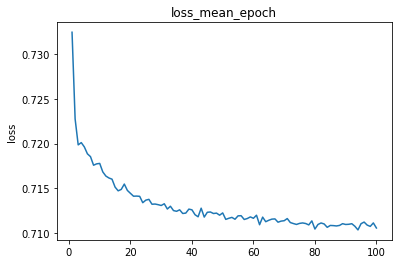

In [15]:
import matplotlib.pyplot as plt
# 每个epoch的平均loss
plt.plot(range(1,len(loss_epochMean_list)+1),loss_epochMean_list)
plt.title('loss_mean_epoch')
plt.ylabel('loss')
plt.show()

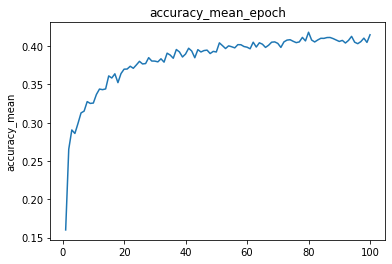

In [14]:
# 每个epoch的平均accuracy
plt.plot(range(1,len(accuracy_mean_list)+1),accuracy_mean_list)
plt.title('accuracy_mean_epoch')
plt.ylabel('accuracy_mean')
plt.show()